## Osztályozási probléma megfogalmazása

Ebben a munkafüzetben egy **bináris osztályozási problémát** vizsgálok videojátékok adatai alapján.

A cél annak előrejelzése, hogy egy videojáték **sikeresnek tekinthető-e**, kizárólag a megjelenéskor ismert jellemzői alapján (például ár, műfaj, kategóriák, megjelenési év).

A „sikerességet” a felhasználói értékelések alapján definiálom.  
Egy játékot **sikeresnek** tekintünk, ha a pozitív értékelések aránya eléri vagy meghaladja a 70%-ot.

A pozitív értékelések arányát a pozitív és negatív értékelések darabszámából számítjuk ki.

**Formálisan:**

- `positive_ratio = positive / (positive + negative)`
- `successful = 1`, ha `positive_ratio ≥ 0.7`
- `successful = 0`, egyébként

Ez egy **felügyelt tanulási (supervised learning)** feladat bináris kimenettel.  
A modell célja annak megtanulása, hogy a megjelenéskor ismert tulajdonságok hogyan befolyásolják a későbbi felhasználói elégedettséget.

Megjegyzés: a sikeresség folytonos formában (pozitív értékelések aránya) is értelmezhető lenne, ezért a probléma regressziós feladatként is megfogalmazható. 
Jelen munkában a cél egy bináris döntési probléma vizsgálata volt (sikeres / nem sikeres játék), amely gyakorlati döntéstámogatási szempontból jól értelmezhető. 
A logisztikus regressziós modell a háttérben valószínűséget becsül, így a regressziós szemlélet részben megjelenik az alkalmazott módszerben.


## Adatok betöltése

In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

DATA_DIR = Path(r"C:\Users\zalma\videogame-data-analysis\split")

# --- FŐ TÁBLA ---
game = pd.read_csv(DATA_DIR / "game.csv")

# --- MŰFAJAK (genres) ---
game_genre = pd.read_csv(DATA_DIR / "game_genre.csv")
genres = pd.read_csv(DATA_DIR / "genres.csv")

# --- KATEGÓRIÁK (categories) ---
game_category = pd.read_csv(DATA_DIR / "game_category.csv")
categories = pd.read_csv(DATA_DIR / "categories.csv")

# --- PLATFORMOK (platforms) ---
game_platform = pd.read_csv(DATA_DIR / "game_platform.csv")
platforms = pd.read_csv(DATA_DIR / "platforms.csv")

print("game shape:", game.shape)
print("game_genre shape:", game_genre.shape, "| genres shape:", genres.shape)
print("game_category shape:", game_category.shape, "| categories shape:", categories.shape)
print("game_platform shape:", game_platform.shape, "| platforms shape:", platforms.shape)

print("\n--- game columns ---")
print(game.columns.tolist())

game.head()

game shape: (112855, 29)
game_genre shape: (112855, 2) | genres shape: (112855, 2)
game_category shape: (112855, 2) | categories shape: (112855, 2)
game_platform shape: (112855, 2) | platforms shape: (112855, 4)

--- game columns ---
['appid', 'name', 'release_date', 'estimated_owners', 'required_age', 'price', 'dlc_count', 'num_recommendations', 'notes', 'website', 'metacritic_score', 'metacritic_url', 'num_achievements', 'user_score', 'score_rank', 'positive', 'negative', 'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks', 'peak_ccu', 'discount', 'pct_pos_total', 'pct_pos_recent', 'num_reviews_total', 'num_reviews_recent', 'reviews', 'english']


,appid,name,release_date,estimated_owners,required_age,price,dlc_count,num_recommendations,notes,website,...,median_playtime_forever,median_playtime_2weeks,peak_ccu,discount,pct_pos_total,pct_pos_recent,num_reviews_total,num_reviews_recent,reviews,english
0,10,Counter-Strike,2000-11-01,10000000 - 20000000,0.0,9.99,0.0,149445.0,Includes intense violence and blood.,NaN,...,0.0,0.0,11703.0,NaN,96.0,95.0,149589.0,908.0,NaN,1.0
1,20,Team Fortress Classic,1999-04-01,5000000 - 10000000,0.0,4.99,0.0,6454.0,Includes intense violence and blood.,NaN,...,15.0,0.0,46.0,0.0,86.0,76.0,6482.0,56.0,NaN,1.0
2,30,Day of Defeat,2003-05-01,5000000 - 10000000,0.0,4.99,0.0,4032.0,NaN,http://www.dayofdefeat.com/,...,0.0,0.0,101.0,NaN,87.0,97.0,4038.0,36.0,NaN,1.0
3,40,Deathmatch Classic,2001-06-01,5000000 - 10000000,0.0,4.99,0.0,2113.0,NaN,NaN,...,7.0,0.0,4.0,NaN,81.0,95.0,2120.0,21.0,NaN,1.0
4,50,Half-Life: Opposing Force,1999-11-01,2000000 - 5000000,0.0,4.99,0.0,18908.0,NaN,NaN,...,161.0,36.0,87.0,NaN,95.0,95.0,18994.0,269.0,NaN,1.0


## Célváltozó (target) létrehozása

A cél annak meghatározása, hogy egy játék **sikeres volt-e** a felhasználói értékelések alapján.  
A `positive` és `negative` oszlopok a pozitív, illetve negatív felhasználói értékelések **darabszámát** tartalmazzák.

Ebben a lépésben ezekből az értékekből kiszámítjuk a pozitív értékelések arányát, majd ebből képezzük a bináris célváltozót (`successful`), amelyet a modell tanításához fogunk használni.

In [2]:
required_cols = {"positive", "negative"}
missing = required_cols - set(game.columns)
if missing:
    raise ValueError(f"Hiányzó oszlop(ok) a game.csv-ben: {missing}")

game["total_reviews"] = game["positive"] + game["negative"]

game["positive_ratio"] = np.where(
    game["total_reviews"] > 0,
    game["positive"] / game["total_reviews"],
    np.nan
)

game["successful"] = (game["positive_ratio"] >= 0.7).astype("float")

print("Értékelés nélküli játékok száma (total_reviews = 0):", (game["total_reviews"] == 0).sum())

game_labeled = game[game["successful"].notna()].copy()
game_labeled["successful"] = game_labeled["successful"].astype(int)

print("\nOsztályeloszlás (darabszám):")
print(game_labeled["successful"].value_counts())

print("\nOsztályeloszlás (arány):")
print(game_labeled["successful"].value_counts(normalize=True))

game_labeled[["appid", "positive", "negative", "positive_ratio", "successful"]].head(10)

Értékelés nélküli játékok száma (total_reviews = 0): 27450

Osztályeloszlás (darabszám):
successful
1    56965
0    55890
Name: count, dtype: int64

Osztályeloszlás (arány):
successful
1    0.504763
0    0.495237
Name: proportion, dtype: float64


,appid,positive,negative,positive_ratio,successful
0,10,230955.0,6024.0,0.974580,1
1,20,7500.0,1121.0,0.869969,1
2,30,6096.0,666.0,0.901508,1
3,40,2438.0,514.0,0.825881,1
4,50,20991.0,1061.0,0.951886,1
5,60,4637.0,1000.0,0.822601,1
6,70,122313.0,4311.0,0.965954,1
7,80,22709.0,2155.0,0.913329,1
8,130,14958.0,1280.0,0.921173,1
9,220,187239.0,4566.0,0.976195,1


## Alap bemeneti változók (feature-ök) előkészítése

Ebben a lépésben kiválasztjuk és előkészítjük azokat az **alap numerikus és logikai változókat**, amelyek már a játék megjelenésekor ismertek, és alkalmasak lehetnek a sikeresség előrejelzésére.

Ide tartoznak például az ár, a korhatár, a megjelenés éve, valamint az, hogy a játék tartalmaz-e angol nyelvi támogatást.


In [3]:
required_features = [
    "appid",
    "price",
    "required_age",
    "dlc_count",
    "english",
    "release_date"
]

missing = set(required_features) - set(game_labeled.columns)
if missing:
    raise ValueError(f"Hiányzó oszlop(ok) a game_labeled-ben: {missing}")

base_features = game_labeled[required_features].copy()

base_features["release_year"] = pd.to_datetime(
    base_features["release_date"],
    errors="coerce"
).dt.year

base_features = base_features.drop(columns=["release_date"])

print("Base features shape:", base_features.shape)
base_features.head()

Base features shape: (112855, 6)


,appid,price,required_age,dlc_count,english,release_year
0,10,9.99,0.0,0.0,1.0,2000.0
1,20,4.99,0.0,0.0,1.0,1999.0
2,30,4.99,0.0,0.0,1.0,2003.0
3,40,4.99,0.0,0.0,1.0,2001.0
4,50,4.99,0.0,0.0,1.0,1999.0


## Műfajok (genres) feldolgozása

A játék–műfaj kapcsolatot a `game_genre.csv` írja le (`appid`, `genreid`), a `genres.csv` pedig a `genreid`-hez tartozó műfajneveket tartalmazza.  
A `genre_name` mezőben több műfaj is szerepelhet, amelyek különböző elválasztójelekkel (`,` és `;`) vannak megadva. Ezeket először elemi műfajokra bontjuk, majd **multi-hot encodingot** készítünk.

In [4]:
gg = game_genre.merge(genres, on="genreid", how="left")

gg = gg[gg["appid"].isin(game_labeled["appid"])].copy()

def split_genres(s: str):
    if pd.isna(s):
        return []
    parts = re.split(r"[;,]", str(s))
    return [p.strip() for p in parts if p.strip()]

gg["genre_list"] = gg["genre_name"].apply(split_genres)

gg_exploded = gg[["appid", "genre_list"]].explode("genre_list")
gg_exploded = gg_exploded.dropna(subset=["genre_list"])

genre_dummies = pd.crosstab(gg_exploded["appid"], gg_exploded["genre_list"])

print("genre_dummies shape:", genre_dummies.shape)
genre_dummies.head()

genre_dummies shape: (106341, 34)


genre_list,360 Video,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Documentary,Early Access,...,Short,Simulation,Software Training,Sports,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing
appid,,,,,,,,,,,,,,,,,,,,,
10,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Kategóriák (categories) feldolgozása

A kategóriák a játék jellemzőit írják le (például: Single-player, Multi-player, Steam Achievements).  
Mivel egy játékhoz több kategória is tartozhat, a kategóriákat **multi-hot encodinggal** ábrázoljuk: minden kategóriához külön bináris oszlopot hozunk létre.

Ebben a lépésben a `game_category.csv` és `categories.csv` táblák alapján elkészítjük a kategóriák 0/1 mátrixát (`category_dummies`).


In [5]:
gc = game_category.merge(categories, on="catid", how="left")

print("gc columns:", gc.columns.tolist())

cat_col = "name"

gc = gc[gc["appid"].isin(game_labeled["appid"])].copy()

def split_cats(s: str):
    if pd.isna(s):
        return []
    parts = re.split(r"[;,]", str(s))
    return [p.strip() for p in parts if p.strip()]

gc["cat_list"] = gc[cat_col].apply(split_cats)

gc_exploded = gc[["appid", "cat_list"]].explode("cat_list")
gc_exploded = gc_exploded.dropna(subset=["cat_list"])

category_dummies = pd.crosstab(gc_exploded["appid"], gc_exploded["cat_list"])

print("category_dummies shape:", category_dummies.shape)
category_dummies.head()

gc columns: ['appid', 'catid', 'name']
category_dummies shape: (105776, 46)


cat_list,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Family Sharing,Full controller support,HDR available,In-App Purchases,Includes Source SDK,Includes level editor,...,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,Tracked Motion Controller Support,VR Only,VR Support,VR Supported,Valve Anti-Cheat enabled
appid,,,,,,,,,,,,,,,,,,,,,
10,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
30,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
40,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
50,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Feature-mátrix (X) és célváltozó (y) összeállítása

Ebben a lépésben az eddig külön-külön előkészített bemeneti változókat
(alap numerikus jellemzők, műfajok és kategóriák)
egyetlen feature-mátrixba (`X`) fűzzük össze.

A célváltozó (`y`) a korábban létrehozott `successful` oszlop lesz.


In [6]:
X = (
    base_features
    .set_index("appid")
    .join(genre_dummies, how="left")
    .join(category_dummies, how="left")
)

X = X.fillna(0)

y = game_labeled.set_index("appid")["successful"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X.head()

X shape: (112855, 85)
y shape: (112855,)


,price,required_age,dlc_count,english,release_year,360 Video,Accounting,Action,Adventure,Animation & Modeling,...,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,Tracked Motion Controller Support,VR Only,VR Support,VR Supported,Valve Anti-Cheat enabled
appid,,,,,,,,,,,,,,,,,,,,,
10,9.99,0.0,0.0,1.0,2000.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20,4.99,0.0,0.0,1.0,1999.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30,4.99,0.0,0.0,1.0,2003.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40,4.99,0.0,0.0,1.0,2001.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50,4.99,0.0,0.0,1.0,1999.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Modell tanítása és kiértékelése (baseline)

Ebben a lépésben az adatokat tanító- és teszthalmazra bontjuk, majd egy egyszerű, jól értelmezhető baseline modellt tanítunk: **Logistic Regression**.

A kiértékeléshez nem csak pontosságot (accuracy) használunk, hanem több metrikát is (precision, recall, F1), valamint a ROC–AUC értéket és a konfúziós mátrixot.


Skálázott numerikus oszlopok: ['price', 'required_age', 'dlc_count', 'english', 'release_year']
              precision    recall  f1-score   support

           0       0.66      0.60      0.63     11178
           1       0.64      0.70      0.67     11393

    accuracy                           0.65     22571
   macro avg       0.65      0.65      0.65     22571
weighted avg       0.65      0.65      0.65     22571

ROC-AUC: 0.7173681517925653


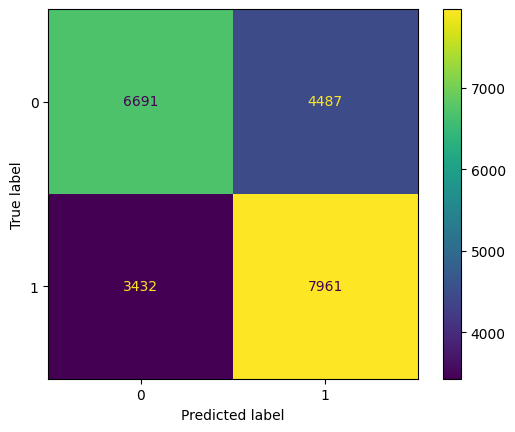

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

candidate_num = ["price", "required_age", "DLC_count", "dlc_count", "english", "release_year"]
num_cols = [c for c in candidate_num if c in X.columns]

print("Skálázott numerikus oszlopok:", num_cols)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
    ],
    remainder="passthrough"
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

## A pozitív értékelések arányának vizsgálata (EDA)


Ebben a részben megvizsgálom, hogy a pozitív értékelések arányának (`positive_ratio`) eloszlását azoknál a játékoknál, amelyekhez érkezett legalább egy értékelés. 
Külön kitérek arra is, hogy az összes játék mekkora részéhez nem érkezett review.


In [8]:
game["total_reviews"] = game["positive"] + game["negative"]

with_reviews = game[game["total_reviews"] > 0].copy()
without_reviews = game[game["total_reviews"] == 0].copy()

print("Játékok száma összesen:", len(game))
print("Értékeléssel rendelkező játékok:", len(with_reviews))
print("Értékelés nélküli játékok:", len(without_reviews))
print("Értékelés nélküli arány:", len(without_reviews) / len(game))

with_reviews["positive_ratio"] = (
    with_reviews["positive"] / with_reviews["total_reviews"]
)

with_reviews["positive_ratio"].describe()


Játékok száma összesen: 112855
Értékeléssel rendelkező játékok: 85405
Értékelés nélküli játékok: 27450
Értékelés nélküli arány: 0.24323246643923618


count    85405.000000
mean         0.748603
std          0.244682
min          0.000000
25%          0.627451
50%          0.809126
75%          0.941176
max          1.000000
Name: positive_ratio, dtype: float64

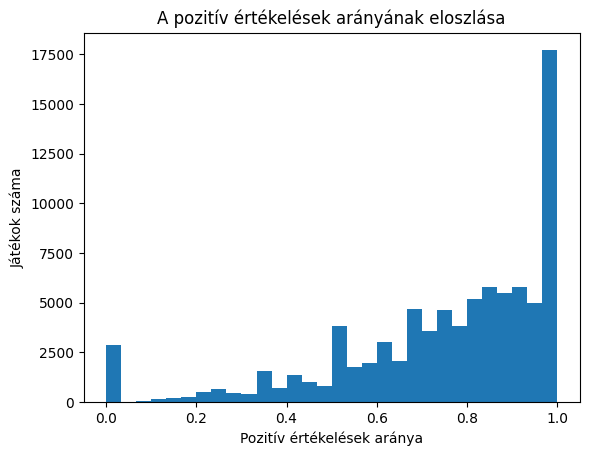

In [9]:
plt.hist(with_reviews["positive_ratio"], bins=30)
plt.xlabel("Pozitív értékelések aránya")
plt.ylabel("Játékok száma")
plt.title("A pozitív értékelések arányának eloszlása")
plt.show()


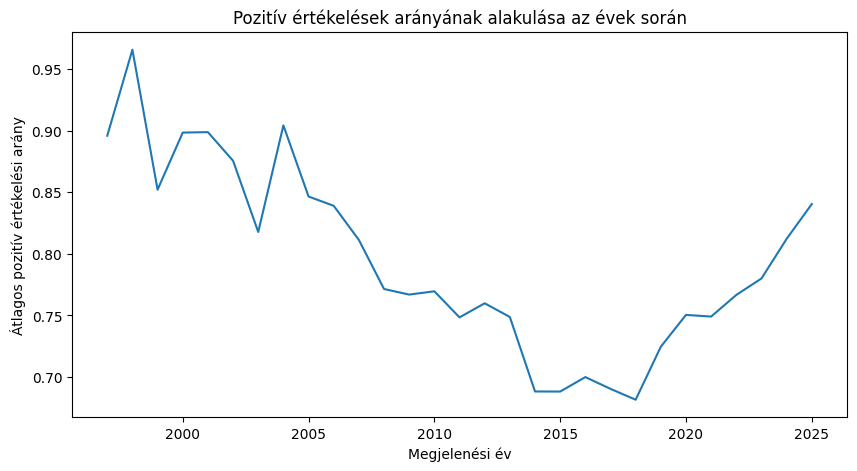

In [10]:
with_reviews["release_year"] = pd.to_datetime(
    with_reviews["release_date"], errors="coerce"
).dt.year

yearly = (
    with_reviews
    .dropna(subset=["release_year"])
    .groupby("release_year")["positive_ratio"]
    .mean()
)

yearly.plot(figsize=(10, 5))
plt.xlabel("Megjelenési év")
plt.ylabel("Átlagos pozitív értékelési arány")
plt.title("Pozitív értékelések arányának alakulása az évek során")
plt.show()


A pozitív értékelések arányának eloszlása erősen felfelé torzított: a játékok többsége magas arányú pozitív visszajelzést kap, amit a 0.8 feletti medián érték is jelez. 
Az adathalmaz jelentős részéhez (közel 24%) nem érkezett egyetlen értékelés sem, ami arra utal, hogy sok játék alacsony láthatóságú vagy kevéssé játszott.

Az évek szerinti bontás alapján megfigyelhető, hogy az átlagos pozitív értékelési arány a korai években magasabb volt, majd a 2010-es évek közepéig csökkenő tendenciát mutatott, ezt követően pedig enyhe emelkedés figyelhető meg. 
Ez arra utalhat, hogy a felhasználói értékelési szokások és a platform jellege időben változott.


A fenti megfigyelések alátámasztják, hogy a sikeresség bináris formában történő modellezése egy egyszerűsítés, ugyanakkor a pozitív értékelési arány önmagában is informatív változó, amely regressziós szemléletben is vizsgálható.


## Alternatív osztályozási módszerek összehasonlítása


A logisztikus regresszió mellett több más, gyakran használt osztályozási módszert is kipróbáltam. 
Mivel a feature-mátrix (X) és a célváltozó (y) már rendelkezésre állt, az összehasonlítás alapértelmezett paraméterekkel történt.


In [11]:
models = {
    "Logistic Regression": clf,
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}

results = []

for name, model in models.items():
    if name == "Logistic Regression":
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_prob)
    results.append((name, auc))

results

[('Logistic Regression', 0.7173681517925653),
 ('Random Forest', 0.7442601529314025),
 ('Gradient Boosting', 0.7539167511850755)]

In [12]:
results_df = pd.DataFrame(results, columns=["Modell", "ROC-AUC"])
results_df.sort_values("ROC-AUC", ascending=False)

,Modell,ROC-AUC
2,Gradient Boosting,0.753917
1,Random Forest,0.744260
0,Logistic Regression,0.717368


A logisztikus regressziót további, gyakran alkalmazott osztályozási módszerekkel is összehasonlítottam. 
Az eredmények alapján a nemlineáris modellek (Random Forest és Gradient Boosting) magasabb ROC–AUC értéket értek el, ami arra utal, hogy a játékok sikeressége és a bemeneti jellemzők közötti kapcsolat részben nemlineáris. 
Ugyanakkor a logisztikus regresszió továbbra is stabil és jól értelmezhető baseline modellt biztosít.


## Feature importance és modellértelmezés


A prediktív teljesítmény mellett azt is megvizsgálom, hogy az egyes bemeneti változók milyen mértékben járulnak hozzá a játékok sikerességének előrejelzéséhez.
A jobb értelmezhetőség érdekében ezt a logisztikus regresszió modell segítségével végzem el.


In [13]:
logreg = clf.named_steps["model"]

feature_names = clf.named_steps["preprocess"].get_feature_names_out()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": logreg.coef_[0]
})

coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

coef_df.head(15)


,feature,coefficient,abs_coef
65,remainder__Remote Play on Tablet,1.084759,1.084759
35,remainder__Utilities,1.084075,1.084075
15,remainder__Education,1.030502,1.030502
43,remainder__Family Sharing,1.013821,1.013821
12,remainder__Design & Illustration,0.930070,0.930070
69,remainder__Single-player,0.883284,0.883284
10,remainder__Audio Production,0.829343,0.829343
31,remainder__Software Training,-0.805574,0.805574
84,remainder__Valve Anti-Cheat enabled,0.773061,0.773061
18,remainder__Free to Play,-0.625082,0.625082


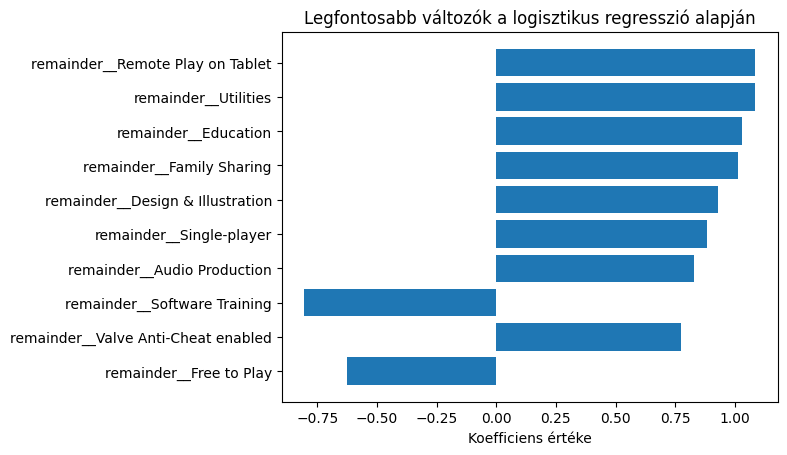

In [14]:
top = coef_df.head(10).iloc[::-1]

plt.barh(top["feature"], top["coefficient"])
plt.xlabel("Koefficiens értéke")
plt.title("Legfontosabb változók a logisztikus regresszió alapján")
plt.show()


A logisztikus regresszió koefficiensei alapján megfigyelhető, hogy a sikerességhez elsősorban nem technikai vagy árazási tényezők járulnak hozzá, hanem a játék (illetve szoftver) jellegével és használati módjával kapcsolatos jellemzők. 
Pozitív hatást mutatnak többek között az egyjátékos mód, a közösségi és kényelmi funkciók (Family Sharing, Steam Cloud, Workshop), valamint bizonyos nem-játék kategóriák.
Negatív irányú hatás figyelhető meg például az ingyenes (Free to Play) modellek, illetve egyes speciális szoftver kategóriák esetében, amelyeknél a felhasználói elégedettség eltérően alakulhat.
